In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 2.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827636 sha256=b1a105d1d1f35859360eb31c6110b70dee867b1fb4aae21661c825e546e0f9c0
  Stored in directory: /Users/anurag/Library/Caches/pip/wheels/af/2b/30/5e78b8b9599f2a2286a582b8da80594f654bf0e18d825a4405
  Created wheel for mdptoolbox-hiive: filename=mdptoolbox_hiive-4.0.3.1-py3-none-any.whl size=35122 sha256=6827abf29433aceeefdb86e354222ed3673a4e2127d11f364f2f35b8b3438231
  Stored in directory: /Users/anurag/Library/Caches/pip/wheels/41/46/f6/64afe48808e5822c79f31a336dd31d05ebe304d45e555fac19
Successfully built gym mdptoolbox-hiive

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import gym
from gym import wrappers
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
#from hiive.mdptoolbox.openai import OpenAI_MDPToolbox
import warnings
warnings.filterwarnings("ignore")

In [7]:
import hiive.mdptoolbox.mdp as a
dir(a)

['FiniteHorizon',
 'MDP',
 'PolicyIteration',
 'PolicyIterationModified',
 'QLearning',
 'RelativeValueIteration',
 'ValueIteration',
 'ValueIterationGS',
 '_LP',
 '_MSG_STOP_EPSILON_OPTIMAL_POLICY',
 '_MSG_STOP_EPSILON_OPTIMAL_VALUE',
 '_MSG_STOP_MAX_ITER',
 '_MSG_STOP_UNCHANGING_POLICY',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_computeDimensions',
 '_math',
 '_np',
 '_printVerbosity',
 '_sp',
 '_time',
 '_util']

In [260]:

class OpenAI_MDPToolbox:

    """Class to convert Discrete Open AI Gym environemnts to MDPToolBox environments. 
    You can find the list of available gym environments here: https://gym.openai.com/envs/#classic_control
    You'll have to look at the source code of the environments for available kwargs; as it is not well documented.  
    """
    
    def __init__(self, openAI_env_name:str, render:bool=False, **kwargs):
        """Create a new instance of the OpenAI_MDPToolbox class
        :param openAI_env_name: Valid name of an Open AI Gym env 
        :type openAI_env_name: str
        :param render: whether to render the Open AI gym env
        :type rander: boolean 
        """
        self.env_name = openAI_env_name
    
        self.env = gym.make(self.env_name, **kwargs)
        self.env.reset(seed = 5)

        if render:
            self.env.render()
        
        self.transitions = self.env.P
        self.actions = int(re.findall(r'\d+', str(self.env.action_space))[0])
        self.states = int(re.findall(r'\d+', str(self.env.observation_space))[0])
        self.P = np.zeros((self.actions, self.states, self.states))
        self.R = np.zeros((self.states, self.actions))
        self.convert_PR()
        
    def convert_PR(self):
        """Converts the transition probabilities provided by env.P to MDPToolbox-compatible P and R arrays
        """
        for state in range(self.states):
            for action in range(self.actions):
                for i in range(len(self.transitions[state][action])):
                    tran_prob = self.transitions[state][action][i][0]
                    state_ = self.transitions[state][action][i][1]
                    self.R[state][action] += tran_prob*self.transitions[state][action][i][2]
                    self.P[action, state, state_] += tran_prob

# Frozen Lake Small Grid

# Value Iteration & Policy Iteration

In [261]:
#env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
gen_map = generate_random_map(size=8)
#mdp_prob = OpenAI_MDPToolbox('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=True)
mdp_prob = OpenAI_MDPToolbox('FrozenLake-v1', desc=gen_map, is_slippery=True)
mdp_p, mdp_r = mdp_prob.P, mdp_prob.R
gamma_val = [0.2,0.4,0.6,0.8, 0.9]

val_iter_df = pd.DataFrame()
pol_iter_df = pd.DataFrame()
for i in gamma_val:
    vi = ValueIteration(mdp_p, mdp_r, max_iter=int(1e10), gamma=i, epsilon = 0.0001)
    vi_df = pd.DataFrame(vi.run())
    vi_df['gamma'] = i
    val_iter_df = val_iter_df.append(vi_df)
    pit = PolicyIteration(mdp_p, mdp_r, max_iter=int(1e10), gamma=i)
    pi_df = pd.DataFrame(pit.run())
    pi_df['gamma'] = i
    pol_iter_df = pol_iter_df.append(pi_df)
#     print("Value Iteration")
#     print(vi_df)
#     print("Policy Iteration")
#     print(pi_df)

In [262]:
print(pol_iter_df)
print(val_iter_df)

   State Action    Reward         Error      Time     Max V    Mean V  \
0   None   None  0.357143  1.594420e-03  0.024093  0.357143  0.005983   
1   None   None  0.358867  1.072892e-04  0.028148  0.358867  0.006039   
2   None   None  0.358867  5.156585e-07  0.029714  0.358867  0.006041   
3   None   None  0.358867  3.719165e-08  0.033748  0.358867  0.006041   
4   None   None  0.358867  2.670241e-09  0.038266  0.358867  0.006041   
5   None   None  0.358867  1.924443e-10  0.040447  0.358867  0.006041   
6   None   None  0.358867  7.277785e-12  0.044881  0.358867  0.006041   
7   None   None  0.358867  3.411863e-13  0.045880  0.358867  0.006041   
8   None   None  0.358867  2.168404e-19  0.048778  0.358867  0.006041   
0   None   None  0.384615  6.963688e-03  0.002351  0.384615  0.006974   
1   None   None  0.392980  9.666008e-04  0.004003  0.392980  0.007268   
2   None   None  0.392983  2.062434e-05  0.006316  0.392983  0.007292   
3   None   None  0.392983  3.316476e-06  0.006611  

In [147]:
val_iter_df

,State,Action,Reward,Error,Time,Max V,Mean V,Iteration,gamma
0,None,None,0.333333,0.333333,0.000154,0.333333,0.010417,1,0.2
1,None,None,0.355556,0.022222,0.000391,0.355556,0.011806,2,0.2
0,None,None,0.333333,0.333333,0.000042,0.333333,0.010417,1,0.4
1,None,None,0.377778,0.044444,0.000098,0.377778,0.013194,2,0.4
2,None,None,0.389630,0.011852,0.000153,0.389630,0.014213,3,0.4
0,None,None,0.333333,0.333333,0.000039,0.333333,0.010417,1,0.6
1,None,None,0.400000,0.066667,0.000091,0.400000,0.014583,2,0.6
2,None,None,0.426667,0.026667,0.000142,0.426667,0.016875,3,0.6
3,None,None,0.437333,0.013333,0.000189,0.437333,0.018083,4,0.6
4,None,None,0.442133,0.006400,0.000236,0.442133,0.018750,5,0.6


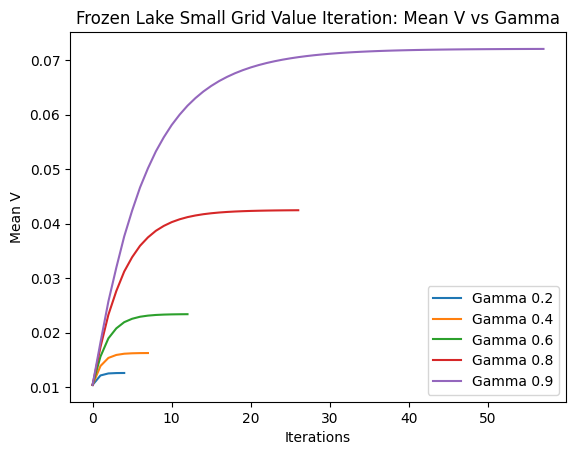

In [234]:
# Value Iteration Gamma plot
plt.figure()
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.2]['Mean V'], label = "Gamma 0.2")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.4]['Mean V'], label = "Gamma 0.4")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.6]['Mean V'], label = "Gamma 0.6")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.8]['Mean V'], label = "Gamma 0.8")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.9]['Mean V'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Mean V')
plt.title('Frozen Lake Small Grid Value Iteration: Mean V vs Gamma')
plt.legend()
plt.savefig('./plots/frozen_small_vi_meanv_gamma.png')
plt.show()

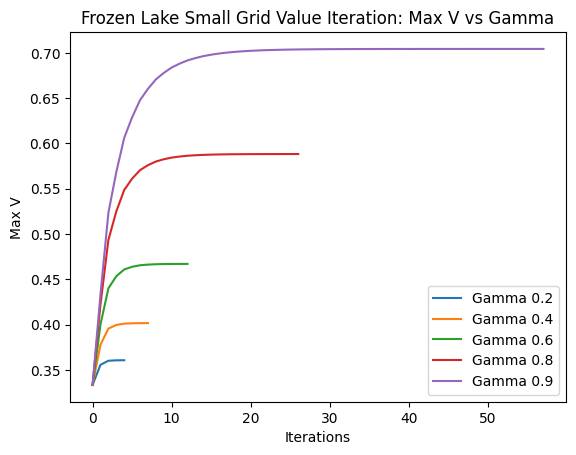

In [235]:
# Value Iteration Gamma plot
plt.figure()
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.2]['Max V'], label = "Gamma 0.2")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.4]['Max V'], label = "Gamma 0.4")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.6]['Max V'], label = "Gamma 0.6")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.8]['Max V'], label = "Gamma 0.8")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.9]['Max V'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Max V')
plt.title('Frozen Lake Small Grid Value Iteration: Max V vs Gamma')
plt.legend()
plt.savefig('./plots/frozen_small_vi_maxv_gamma.png')
plt.show()

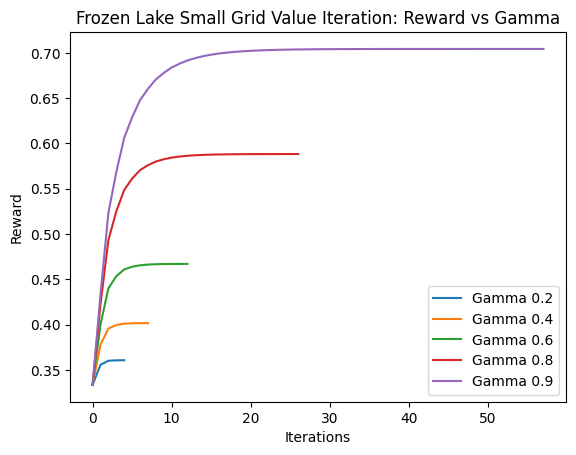

In [236]:
# Value Iteration Reward plot
plt.figure()
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.2]['Reward'], label = "Gamma 0.2")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.4]['Reward'], label = "Gamma 0.4")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.6]['Reward'], label = "Gamma 0.6")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.8]['Reward'], label = "Gamma 0.8")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.9]['Reward'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title('Frozen Lake Small Grid Value Iteration: Reward vs Gamma')
plt.legend()
plt.savefig('./plots/frozen_small_vi_rewards_gamma.png')
plt.show()

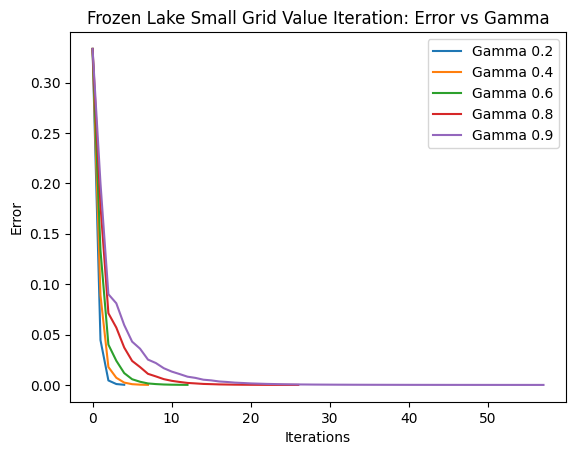

In [237]:
# Value Iteration Error plot
plt.figure()
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.2]['Error'], label = "Gamma 0.2")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.4]['Error'], label = "Gamma 0.4")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.6]['Error'], label = "Gamma 0.6")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.8]['Error'], label = "Gamma 0.8")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.9]['Error'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Frozen Lake Small Grid Value Iteration: Error vs Gamma')
plt.legend()
plt.savefig('./plots/frozen_small_vi_error_gamma.png')
plt.show()

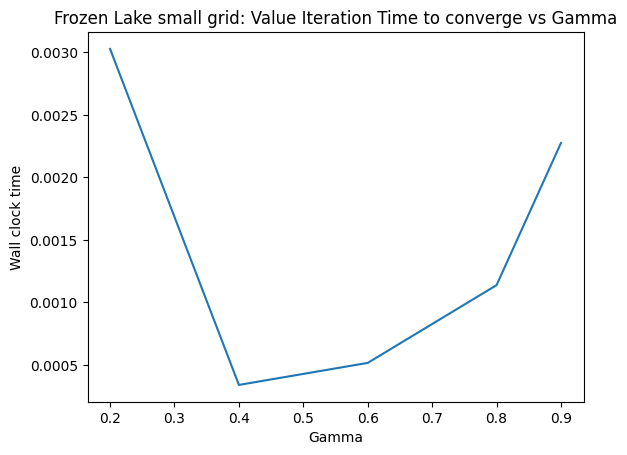

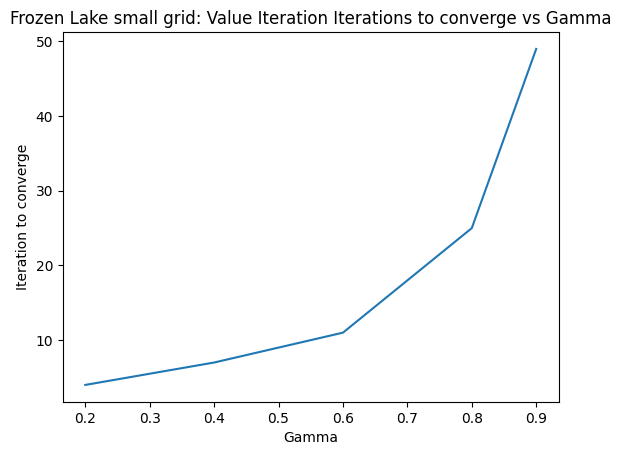

In [263]:
vlg = pd.DataFrame(val_iter_df[['gamma','Time','Iteration','Max V']].
                   groupby('gamma').apply(lambda x: x.iloc[[ -1]]))
# print(vlg)

plt.plot(vlg['gamma'], vlg['Time'])
plt.xlabel('Gamma')
plt.ylabel('Wall clock time')
plt.title('Frozen Lake small grid: Value Iteration Time to converge vs Gamma')
#plt.savefig('./plots/frozen_small_vi_time_gamma.png')
plt.show()

plt.plot(vlg['gamma'], vlg['Iteration'])
plt.xlabel('Gamma')
plt.ylabel('Iteration to converge')
plt.title('Frozen Lake small grid: Value Iteration Iterations to converge vs Gamma')
#plt.savefig('./plots/frozen_small_vi_iterations_gamma.png')
plt.show()

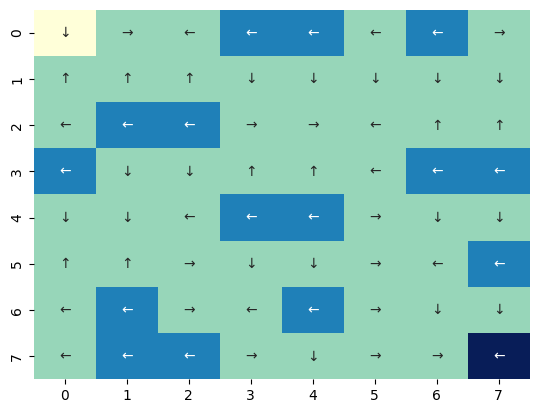

In [239]:
vi = ValueIteration(mdp_p, mdp_r, max_iter=int(1e10), gamma=0.9, epsilon = 0.0001)
vi.run()
policy = vi.policy
policy = np.reshape(policy, (8,8)).astype(str)
lake_map = gen_map
def generate_map(policy, lake_map):
    policy[policy == '0'] = "\u2190"
    policy[policy == '1'] = "\u2193"
    policy[policy == '2'] = "\u2192"
    policy[policy == '3'] = "\u2191"
    
    dict_map = {'S':0,'F':1,'H':2,'G':3}
    
    grid_array = []
    for i in lake_map:
        gridi = [dict_map[j] for j in i]
        grid_array.append(gridi)
    grid_array = np.array(grid_array)
    sns_heatmap = sns.heatmap(grid_array, cmap="YlGnBu", annot = policy, cbar=False, fmt='')
    plt.savefig('./plots/frozen_small_vi_policy_viz.png')
    plt.show()
    
generate_map(policy, lake_map)    

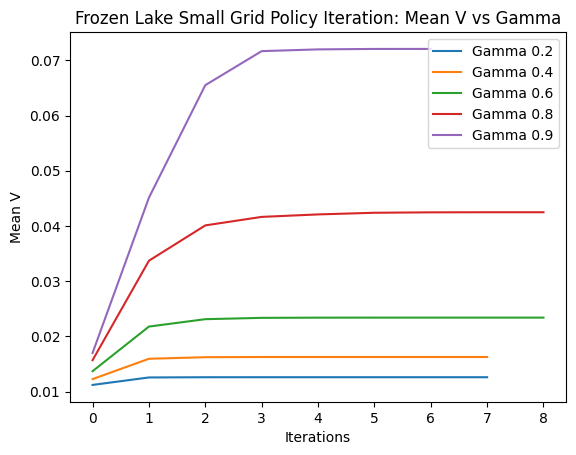

In [240]:
# Policy Iteration Gamma plot
plt.figure()
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.2]['Mean V'], label = "Gamma 0.2")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.4]['Mean V'], label = "Gamma 0.4")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.6]['Mean V'], label = "Gamma 0.6")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.8]['Mean V'], label = "Gamma 0.8")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.9]['Mean V'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Mean V')
plt.title('Frozen Lake Small Grid Policy Iteration: Mean V vs Gamma')
plt.legend()
plt.savefig('./plots/frozen_small_pi_meanv_gamma.png')
plt.show()

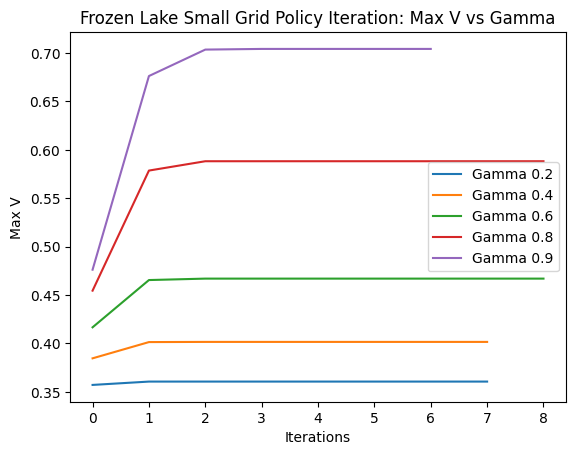

In [241]:
# Policy Iteration Gamma plot
plt.figure()
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.2]['Max V'], label = "Gamma 0.2")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.4]['Max V'], label = "Gamma 0.4")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.6]['Max V'], label = "Gamma 0.6")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.8]['Max V'], label = "Gamma 0.8")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.9]['Max V'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Max V')
plt.title('Frozen Lake Small Grid Policy Iteration: Max V vs Gamma')
plt.legend()
plt.savefig('./plots/frozen_small_pi_maxv_gamma.png')
plt.show()

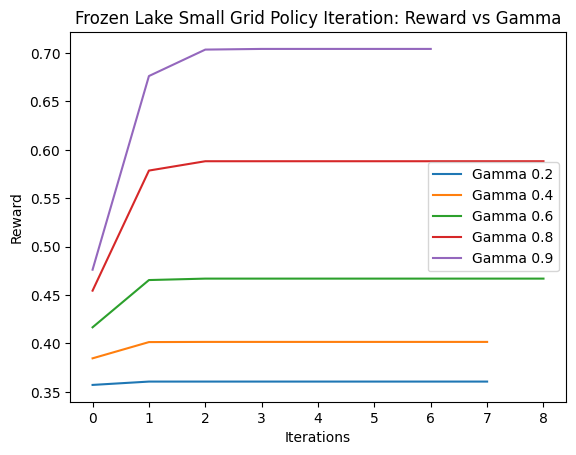

In [244]:
# Policy Iteration Reward plot
plt.figure()
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.2]['Reward'], label = "Gamma 0.2")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.4]['Reward'], label = "Gamma 0.4")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.6]['Reward'], label = "Gamma 0.6")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.8]['Reward'], label = "Gamma 0.8")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.9]['Reward'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title('Frozen Lake Small Grid Policy Iteration: Reward vs Gamma')
plt.legend()
plt.savefig('./plots/frozen_small_pi_reward_gamma.png')
plt.show()

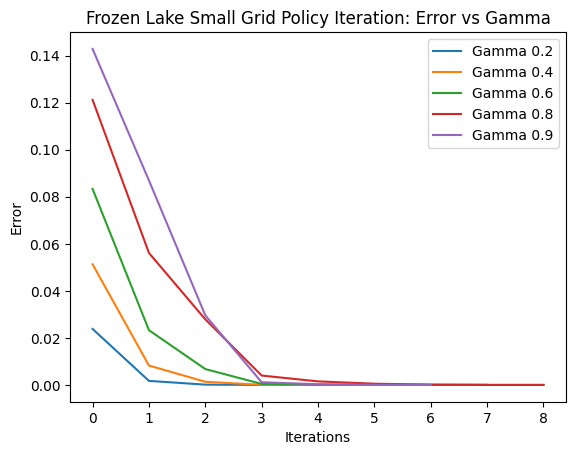

In [246]:
# Policy Iteration Error plot
plt.figure()
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.2]['Error'], label = "Gamma 0.2")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.4]['Error'], label = "Gamma 0.4")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.6]['Error'], label = "Gamma 0.6")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.8]['Error'], label = "Gamma 0.8")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.9]['Error'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Frozen Lake Small Grid Policy Iteration: Error vs Gamma')
plt.legend()
plt.savefig('./plots/frozen_small_pi_error_gamma.png')
plt.show()

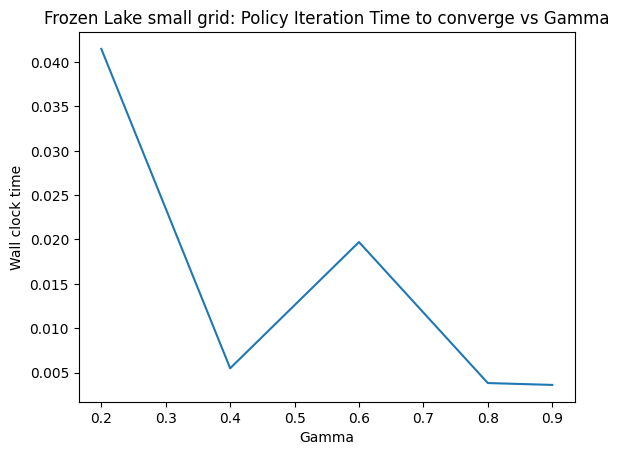

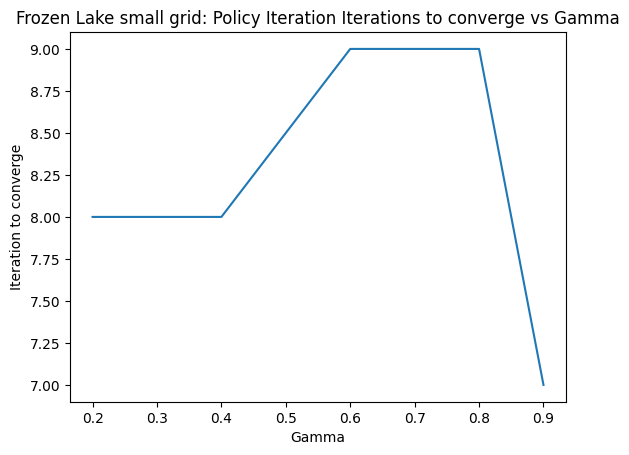

In [247]:
plg = pd.DataFrame(pol_iter_df[['gamma','Time','Iteration','Max V']].
                   groupby('gamma').apply(lambda x: x.iloc[[ -1]]))
# print(vlg)

plt.plot(plg['gamma'], plg['Time'])
plt.xlabel('Gamma')
plt.ylabel('Wall clock time')
plt.title('Frozen Lake small grid: Policy Iteration Time to converge vs Gamma')
plt.savefig('./plots/frozen_small_pi_time_gamma.png')
plt.show()

plt.plot(plg['gamma'], plg['Iteration'])
plt.xlabel('Gamma')
plt.ylabel('Iteration to converge')
plt.title('Frozen Lake small grid: Policy Iteration Iterations to converge vs Gamma')
plt.savefig('./plots/frozen_small_pi_iterations_gamma.png')
plt.show()

In [ ]:
pol_iter_df

In [ ]:
val_iter_df

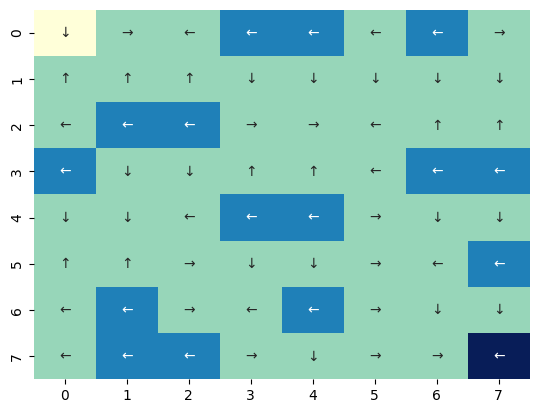

In [248]:
pi = PolicyIteration(mdp_p, mdp_r, max_iter=int(1e10), gamma=0.9)
pi.run()
policy = pi.policy
policy = np.reshape(policy, (8,8)).astype(str)
lake_map = gen_map
def generate_map(policy, lake_map):
    policy[policy == '0'] = "\u2190"
    policy[policy == '1'] = "\u2193"
    policy[policy == '2'] = "\u2192"
    policy[policy == '3'] = "\u2191"
    
    dict_map = {'S':0,'F':1,'H':2,'G':3}
    
    grid_array = []
    for i in lake_map:
        gridi = [dict_map[j] for j in i]
        grid_array.append(gridi)
    grid_array = np.array(grid_array)
    sns_heatmap = sns.heatmap(grid_array, cmap="YlGnBu", annot = policy, cbar=False, fmt='')
    plt.savefig('./plots/frozen_small_pi_policy_viz.png')
    plt.show()
    
generate_map(policy, lake_map)    

# Q Learning

In [ ]:
# Reference: https://www.baeldung.com/cs/epsilon-greedy-q-learning


In [223]:
def run_ql(gamma_val=[0.8], alpha_val=[1], epsilon_val=[1], ad=[0.9], ed=[0.95], iteration=[1e5]):
   
    
    ind_size = len(gamma_val)*len(alpha_val)*len(epsilon_val)*len(ad)*len(ed)*len(iteration)
    ql_df = pd.DataFrame(0,index=np.arange(ind_size), 
                         columns=['gamma','alpha','epsilon','alpha_decay','epsilon_decay','time',
                                  'iterations','reward','mean_rewards','max_rewards','error','policy'])
    qlearn_df = pd.DataFrame()
    counter_val = 0
    for j in alpha_val:
        for k in epsilon_val:
            for l in ad:
                for m in ed:
                    for n in iteration:
#                         ql = QLearning(mdp_p, mdp_r, n_iter=n, gamma=0.8, alpha=j, epsilon=k,
#                                        alpha_decay=l, epsilon_decay=m, alpha_min=0.001)
                        ql = QLearning(mdp_p, mdp_r, n_iter=n, gamma=0.9, alpha=j, epsilon=k
                                       )
                        qlo = ql.run()
                        temp_df = pd.DataFrame(qlo)
                        #print(len(qlo))
                        temp_df['gamma'] = 0.9
                        temp_df['alpha'] = j
                        temp_df['epsilon'] = k
                        temp_df['alpha_decay'] = l
                        temp_df['epsilon_decay'] = m
                        temp_df['n_iter'] = n
                        time  = qlo[-1]['Time']
                        iters = qlo[-1]['Iteration']
                        max_val  = qlo[-1]['Max V']
                        max_rewards, mean_rewards, errors = [], [], []
                        for o in qlo:
                            max_rewards.append(o['Max V'])
                            mean_rewards.append(o['Mean V'])
                            errors.append(o['Error']) 
                        policy = np.array(ql.policy)
                        policy = np.reshape(policy, (8,8))
                        
                        ql_df['gamma'][counter_val] = 0.9
                        ql_df['alpha'][counter_val] = j
                        ql_df['epsilon'][counter_val] = k
                        ql_df['alpha_decay'][counter_val] = l
                        ql_df['epsilon_decay'][counter_val] = m
                        ql_df['time'][counter_val] = time
                        ql_df['iterations'][counter_val] = iters
                        ql_df['reward'][counter_val] = max_val
                        ql_df['mean_rewards'][counter_val] = {tuple(mean_rewards)}
                        ql_df['max_rewards'][counter_val] = {tuple(max_rewards)}
                        ql_df['error'][counter_val] = {tuple(errors)}
                        ql_df['policy'][counter_val] = {ql.policy}
                        
                        counter_val += 1
                        
                        
                        qlearn_df = qlearn_df.append(temp_df)
                        
                        
    return ql_df,qlearn_df
                        
                        


In [227]:
init_time = time.time()
ql_df,qlearn_df = run_ql(gamma_val=[0.9], alpha_val=[0.1], epsilon_val=[0.1,0.2,0.4,0.6,0.8,0.9], ad=[0.9], ed=[0.95], iteration=[1e7])
print("Time taken to run:", time.time() - init_time)

Time taken to run: 1980.9000470638275


In [ ]:
def run_ql(gamma_val=[0.8], alpha_val=[1], epsilon_val=[1], ad=[0.9], ed=[0.95], iteration=[1e5]):
   
    
    ind_size = len(gamma_val)*len(alpha_val)*len(epsilon_val)*len(ad)*len(ed)*len(iteration)
    ql_df = pd.DataFrame(0,index=np.arange(ind_size), 
                         columns=['gamma','alpha','epsilon','alpha_decay','epsilon_decay','time',
                                  'iterations','reward','mean_rewards','max_rewards','error','policy'])
    qlearn_df = pd.DataFrame()
    counter_val = 0
    for j in alpha_val:
        for k in epsilon_val:
            for l in ad:
                for m in ed:
                    for n in iteration:
#                         ql = QLearning(mdp_p, mdp_r, n_iter=n, gamma=0.8, alpha=j, epsilon=k,
#                                        alpha_decay=l, epsilon_decay=m, alpha_min=0.001)
                        ql = QLearning(mdp_p, mdp_r, n_iter=n, gamma=0.8, alpha=j, epsilon=k
                                       )
                        qlo = ql.run()
                        temp_df = pd.DataFrame(qlo)
                        #print(len(qlo))
                        temp_df['gamma'] = 0.8
                        temp_df['alpha'] = j
                        temp_df['epsilon'] = k
                        temp_df['alpha_decay'] = l
                        temp_df['epsilon_decay'] = m
                        temp_df['n_iter'] = n
                        time  = qlo[-1]['Time']
                        iters = qlo[-1]['Iteration']
                        max_val  = qlo[-1]['Max V']
                        max_rewards, mean_rewards, errors = [], [], []
                        for o in qlo:
                            max_rewards.append(o['Max V'])
                            mean_rewards.append(o['Mean V'])
                            errors.append(o['Error']) 
                        policy = np.array(ql.policy)
                        policy = np.reshape(policy, (8,8))
                        
                        ql_df['gamma'][counter_val] = 0.8
                        ql_df['alpha'][counter_val] = j
                        ql_df['epsilon'][counter_val] = k
                        ql_df['alpha_decay'][counter_val] = l
                        ql_df['epsilon_decay'][counter_val] = m
                        ql_df['time'][counter_val] = time
                        ql_df['iterations'][counter_val] = iters
                        ql_df['reward'][counter_val] = max_val
                        ql_df['mean_rewards'][counter_val] = {tuple(mean_rewards)}
                        ql_df['max_rewards'][counter_val] = {tuple(max_rewards)}
                        ql_df['error'][counter_val] = {tuple(errors)}
                        ql_df['policy'][counter_val] = {ql.policy}
                        
                        counter_val += 1
                        
                        
                        qlearn_df = qlearn_df.append(temp_df)
                        
                        
    return ql_df,qlearn_df
                        
                        



In [188]:
ql_df

,gamma,alpha,epsilon,alpha_decay,epsilon_decay,time,iterations,reward,mean_rewards,max_rewards,error,policy
0,0.8,0.8,0.1,0.9,0.95,3.410095,100000,0.011471,"{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0,..."
1,0.8,0.8,0.2,0.9,0.95,3.343263,100000,0.012757,"{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0, 2, 3, 3, 2, 2, 1, 0, 1, 1, 1, 2, 3, 0, 2,..."
2,0.8,0.8,0.4,0.9,0.95,3.450416,100000,0.012114,"{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 3, 0, 0,..."
3,0.8,0.8,0.6,0.9,0.95,3.371052,100000,0.011471,"{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(3, 3, 3, 1, 0, 0, 0, 0, 3, 3, 3, 2, 2, 1, 0,..."
4,0.8,0.8,0.8,0.9,0.95,3.381360,100000,0.009857,"{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0, 2, 0, 2, 1, 2, 3, 0, 2, 1, 1, 1, 3, 3, 1,..."
5,0.8,0.8,0.9,0.9,0.95,3.381983,100000,0.016677,"{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(2, 3, 2, 2, 0, 3, 2, 0, 3, 3, 2, 2, 1, 1, 2,..."


In [189]:
qlearn_df

,State,Action,Reward,Error,Time,Alpha,Epsilon,Gamma,Max V,Mean V,Iteration,gamma,alpha,epsilon,alpha_decay,epsilon_decay,n_iter
0,2,0,0.0,0.0,0.000242,0.001,0.1,0.8,0.011471,0.000248,10,0.8,0.8,0.1,0.9,0.95,100000.0
1,16,0,0.0,0.0,0.000525,0.001,0.1,0.8,0.011471,0.000248,20,0.8,0.8,0.1,0.9,0.95,100000.0
2,16,0,0.0,0.0,0.000787,0.001,0.1,0.8,0.011471,0.000248,30,0.8,0.8,0.1,0.9,0.95,100000.0
3,16,0,0.0,0.0,0.001052,0.001,0.1,0.8,0.011471,0.000248,40,0.8,0.8,0.1,0.9,0.95,100000.0
4,49,0,0.0,0.0,0.001410,0.001,0.1,0.8,0.011471,0.000248,50,0.8,0.8,0.1,0.9,0.95,100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,35,0,0.0,0.0,3.379601,0.001,0.1,0.8,0.040859,0.001015,99960,0.8,0.8,0.9,0.9,0.95,100000.0
9996,35,0,0.0,0.0,3.379936,0.001,0.1,0.8,0.040859,0.001015,99970,0.8,0.8,0.9,0.9,0.95,100000.0
9997,35,0,0.0,0.0,3.380279,0.001,0.1,0.8,0.040859,0.001015,99980,0.8,0.8,0.9,0.9,0.95,100000.0
9998,35,0,0.0,0.0,3.380621,0.001,0.1,0.8,0.040859,0.001015,99990,0.8,0.8,0.9,0.9,0.95,100000.0


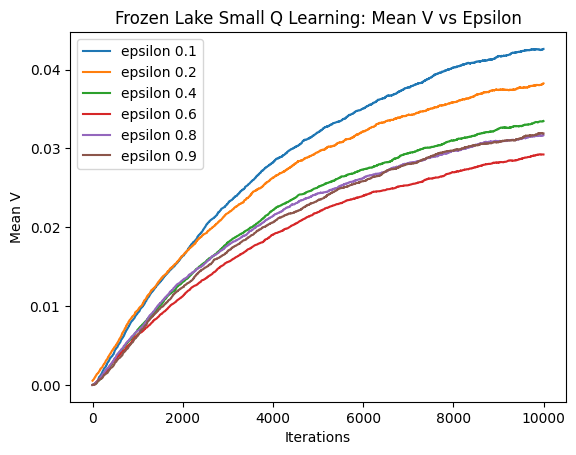

In [252]:
plt.figure()
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.1]['Mean V'], label = "epsilon 0.1")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.2]['Mean V'], label = "epsilon 0.2")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.4]['Mean V'], label = "epsilon 0.4")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.6]['Mean V'], label = "epsilon 0.6")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.8]['Mean V'], label = "epsilon 0.8")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.9]['Mean V'], label = "epsilon 0.9")
plt.xlabel('Iterations')
plt.ylabel('Mean V')
plt.title('Frozen Lake Small Q Learning: Mean V vs Epsilon')
plt.legend()
plt.savefig('./plots/frozen_small_QL_meanv_eps.png')
plt.show()

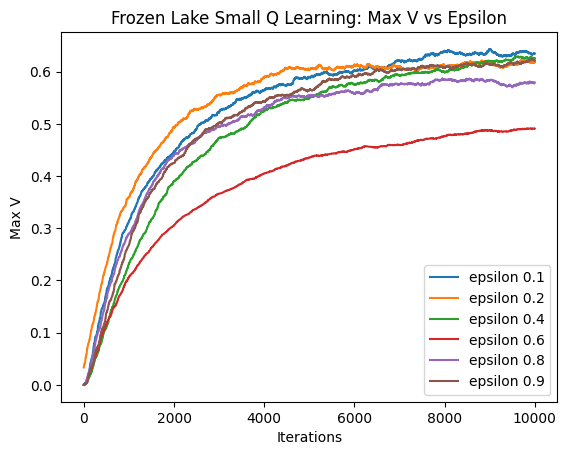

In [253]:
plt.figure()
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.1]['Max V'], label = "epsilon 0.1")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.2]['Max V'], label = "epsilon 0.2")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.4]['Max V'], label = "epsilon 0.4")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.6]['Max V'], label = "epsilon 0.6")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.8]['Max V'], label = "epsilon 0.8")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.9]['Max V'], label = "epsilon 0.9")
plt.xlabel('Iterations')
plt.ylabel('Max V')
plt.title('Frozen Lake Small Q Learning: Max V vs Epsilon')
plt.legend()
plt.savefig('./plots/frozen_small_QL_maxv_eps.png')
plt.show()

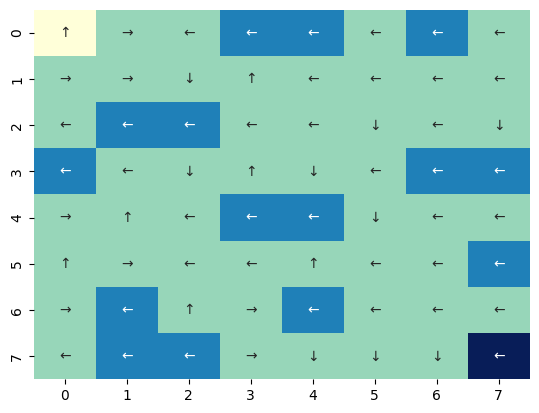

In [254]:
ql = QLearning(mdp_p, mdp_r, n_iter=1e7, gamma=0.9, alpha=0.1, epsilon=0.1)
ql.run()
policy = ql.policy
policy = np.reshape(policy, (8,8)).astype(str)
lake_map = gen_map
def generate_map(policy, lake_map):
    policy[policy == '0'] = "\u2190"
    policy[policy == '1'] = "\u2193"
    policy[policy == '2'] = "\u2192"
    policy[policy == '3'] = "\u2191"
    
    dict_map = {'S':0,'F':1,'H':2,'G':3}
    
    grid_array = []
    for i in lake_map:
        gridi = [dict_map[j] for j in i]
        grid_array.append(gridi)
    grid_array = np.array(grid_array)
    sns_heatmap = sns.heatmap(grid_array, cmap="YlGnBu", annot = policy, cbar=False, fmt='')
    plt.savefig('./plots/frozen_small_QL_policy_viz.png')
    plt.show()
    
generate_map(policy, lake_map)    

              epsilon        Time  Iteration     Max V
epsilon                                               
0.1     9999      0.1  330.756634   10000000  0.634635
0.2     9999      0.2  328.302714   10000000  0.618699
0.4     9999      0.4  328.388814   10000000  0.625332
0.6     9999      0.6  328.498554   10000000  0.491035
0.8     9999      0.8  332.565858   10000000  0.579237
0.9     9999      0.9  331.966502   10000000  0.621407


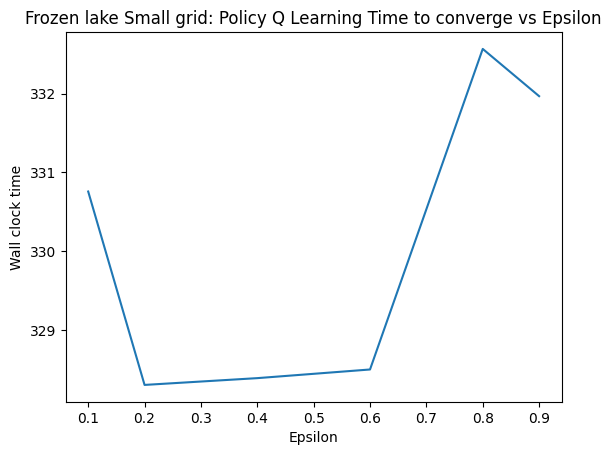

In [258]:
qlg = pd.DataFrame(qlearn_df[['epsilon','Time','Iteration','Max V']].
                   groupby('epsilon').apply(lambda x: x.iloc[[ -1]]))
print(qlg)

plt.plot(qlg['epsilon'], qlg['Time'])
plt.xlabel('Epsilon')
plt.ylabel('Wall clock time')
plt.title('Frozen lake Small grid: Policy Q Learning Time to converge vs Epsilon')
plt.savefig('./plots/frozen_small_ql_time_eps.png')
plt.show()